# One automated score, many raters

This notebooks looks at one automated score evaluated against multiple human raters.

In [7]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from pathlib import Path

from rsmtool.analyzer import Analyzer

import json

%matplotlib inline

In [2]:
config = json.load(open('settings.json'))
total_n_raters = sum(config['n_raters'])
fig_dir = Path('../paper_overleaf/figures')
df = pd.read_csv('../data/data.csv')
df_raters = pd.read_csv('../data/raters.csv')
df_systems = pd.read_csv('../data/systems.csv')
metrics_dict = json.load(open('metrics_dict.json'))
df['system'] = df[config['sample_system']]

In [3]:
# compute the cumulative mean of human scores per category.
agg_list = []
diff_list = []
for category in df_raters['category'].unique():
    human_columns_category = df_raters[df_raters['category']==category]['rater_id']
    df_agg = df[human_columns_category].expanding(min_periods=1, axis=1).mean()
    df_agg.columns = ['N={}'.format(n) for n in range(1, len(human_columns_category)+1)]
    df_difference = df_agg.subtract(df['true'], axis=0)
    df_agg['category'] = category
    df_difference['category'] = category
    df_agg['id'] = df['id']
    agg_list.append(df_agg)
    diff_list.append(df_difference)

In [4]:
df_agg = pd.concat(agg_list)
df_diff = pd.concat(diff_list)

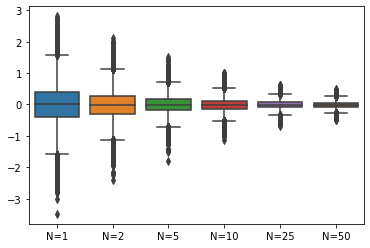

In [8]:
#Plot difference for key N raters: the plot shows that the scores get closer to true score as the 
# number of raters increases
sns.boxplot(data=df_diff[['N={}'.format(i) for i in config['key_steps_n_raters']]])

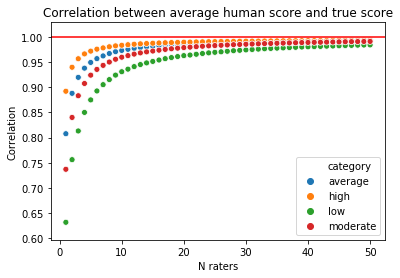

In [9]:
# correlation between human score and true score
corr_true = df_agg.groupby('category').corrwith(df['true']).unstack().reset_index()
corr_true.columns = ['N_raters', 'category', 'correlation']
corr_true['N'] = corr_true['N_raters'].apply(lambda x: int(x.split('=')[1]))
ax = sns.scatterplot(x='N', y='correlation', hue='category', data=corr_true)
ax.axhline(1, color='red')
ax.set_xlabel("N raters")
ax.set_ylabel("Correlation")
ax.set_title("Correlation between average human score and true score");

## Correlation with a sample system

In [10]:
# Compute correlation with gold-standard
true_eval = Analyzer.metrics_helper(df['true'], df['system'])
true_eval.rename(index=metrics_dict, inplace=True)
true_eval

kappa            0.605565
QWK              0.908822
exact_agr        0.000000
adj_agr         99.750000
SMD              0.001948
r                0.912429
R2               0.799869
RMSE             0.332323
sys_min          0.944025
sys_max          6.633447
sys_mean         3.845731
sys_sd           0.812078
h_min            1.401941
h_max            6.000000
h_mean           3.844283
h_sd             0.742891
N            10000.000000
dtype: float64

In [11]:
# define a function to compute metrics against aggregated scores
def compute_metrics(df_cat):
    metrics_n = []
    for c in df_cat.columns:
        if c.startswith("N="):
            df_metrics = pd.DataFrame(Analyzer.metrics_helper(df_cat[c], df['system'])).transpose()
            df_metrics.index = [int(c.split('=')[1])]
            df_metrics.index.name = 'N raters'
            metrics_n.append(df_metrics)
    return pd.concat(metrics_n)

In [12]:
# this computes metrics over 200 raters so can take some time
df_metrics = df_agg.groupby('category').apply(compute_metrics).reset_index()

In [11]:
# rename the metrics and melt the dataframe
df_metrics = df_metrics.rename(columns=metrics_dict)
df_metrics_long = df_metrics.melt(id_vars=['category', 'N raters'], 
                                  value_vars=['r', 'R2', 'QWK'],
                                  var_name='metrics',
                                  value_name='value')

In [12]:
# Create the plot

g=sns.lmplot(x='N raters', y='value', col='metrics', hue='category', data=df_metrics_long,
            fit_reg=False, hue_order = config['rater_categories'],
            col_order=['r', 'R2', 'QWK'], sharey=False)
axes = g.axes[0]

for ax in axes:
    metric = ax.get_title().split('=')[1].strip()
    line_height = true_eval[metric]
    ax.axhline(line_height, color='red')
    
g.savefig(fig_dir / 'intuition.png')